In [10]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report
import sys
sys.path.append('../Utils')
import configs

# ---------------- CONFIG ----------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
USE_PRETRAINED = True          # Use pretrained CNN
FREEZE_CNN = False             # Fine-tune CNN for better accuracy
BACKBONE = "resnet18"          # resnet18 or resnet50
NUM_CLASSES = 7
NUM_EPOCHS = 50
BATCH_SIZE = 16
LR = 1e-4
WEIGHT_DECAY = 1e-5
NUM_VIEWS = getattr(configs, "NUM_VIEWS", 5)

# Data paths from configs.py
MULTIVIEW_TRAIN_DIR, MULTIVIEW_TEST_DIR = configs.MULTIVIEW_TRAIN_DIR, configs.MULTIVIEW_TEST_DIR
TRAIN_FEATURES_DIR, TEST_FEATURES_DIR   = configs.TRAIN_FEATURES_DIR, configs.TEST_FEATURES_DIR

print(f"Using device: {DEVICE}")


Using device: mps


In [11]:
# ---------------- DATA: Classical Descriptors ----------------
train_lbp = np.load(TRAIN_FEATURES_DIR / "features.npy")
train_labels = np.load(TRAIN_FEATURES_DIR / "labels.npy")
test_lbp  = np.load(TEST_FEATURES_DIR / "features.npy")
test_labels  = np.load(TEST_FEATURES_DIR / "labels.npy")

# Normalize LBP features
mean_lbp = train_lbp.mean(axis=0, keepdims=True)
std_lbp  = train_lbp.std(axis=0, keepdims=True) + 1e-6
train_lbp = (train_lbp - mean_lbp) / std_lbp
test_lbp  = (test_lbp - mean_lbp) / std_lbp

LBP_DIM = train_lbp.shape[1]

print(f"Train Shape  Features: {train_lbp.shape} | Labels: {train_labels.shape}")
print(f"Test Shape Features: {test_lbp.shape} | Labels: {test_labels.shape}")


Train Shape  Features: (2785, 26) | Labels: (2785,)
Test Shape Features: (670, 26) | Labels: (670,)


In [12]:
# ---------------- TRANSFORMS ----------------
tfm = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

# ---------------- DATASETS ----------------
train_set = datasets.ImageFolder(root=MULTIVIEW_TRAIN_DIR, transform=tfm['train'])
test_set  = datasets.ImageFolder(root=MULTIVIEW_TEST_DIR, transform=tfm['test'])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("\nDataset Info:")
print(f"Train size: {len(train_set)} | Test size: {len(test_set)} | Classes: {train_set.classes}")



Dataset Info:
Train size: 2785 | Test size: 670 | Classes: ['Ash', 'Beech', 'Douglas Fir', 'Oak', 'Pine', 'Red Oak', 'Spruce']


In [13]:
# ---------------- MODEL ----------------
def make_backbone(name="resnet18", pretrained=True):
    if name=="resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        return nn.Sequential(*list(m.children())[:-1]), 512
    if name=="resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
        return nn.Sequential(*list(m.children())[:-1]), 2048

class FusionModel(nn.Module):
    def __init__(self, cnn_dim, lbp_dim, num_classes):
        super().__init__()
        self.cnn, self.cnn_dim = make_backbone(BACKBONE, USE_PRETRAINED)
        if FREEZE_CNN:
            for p in self.cnn.parameters(): 
                p.requires_grad = False

        # Fusion fully-connected layers
        self.fc = nn.Sequential(
            nn.Linear(cnn_dim + lbp_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, lbp):
        f = self.cnn(x).view(x.size(0), -1)
        lbp = lbp.to(f.device)
        fused = torch.cat([f, lbp], dim=1)
        return self.fc(fused)

cnn_dim = 512 if BACKBONE=="resnet18" else 2048
model = FusionModel(cnn_dim, LBP_DIM, NUM_CLASSES).to(DEVICE)
crit = nn.CrossEntropyLoss()
opt = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)


In [14]:
def train_model(model, train_loader, val_loader, lbp_train, lbp_val, optimizer, criterion, device, num_epochs=10):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # ---------------- TRAIN ----------------
        model.train()
        tot, correct, loss_sum = 0, 0, 0

        for i, (x, y) in enumerate(train_loader):
            lbp = torch.tensor(lbp_train[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]).float()
            x, y, lbp = x.to(device), y.to(device), lbp.to(device)

            optimizer.zero_grad()
            out = model(x, lbp)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * y.size(0)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            tot += y.size(0)

        train_loss = loss_sum / tot
        train_acc  = 100 * correct / tot
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # ---------------- VALIDATION ----------------
        val_loss, val_acc, _, _ = eval_model(model, val_loader, lbp_val, criterion, device)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return history


In [15]:
def eval_model(model, data_loader, lbp_features, criterion=None, device="cpu"):

    model.eval()
    all_preds, all_labels = [], []
    tot, correct, loss_sum = 0, 0, 0

    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            lbp = torch.tensor(lbp_features[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]).float()
            x, y, lbp = x.to(device), y.to(device), lbp.to(device)

            out = model(x, lbp)
            preds = out.argmax(1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

            correct += (preds == y).sum().item()
            tot += y.size(0)

            if criterion:
                loss = criterion(out, y)
                loss_sum += loss.item() * y.size(0)

    acc = 100 * correct / tot
    avg_loss = loss_sum / tot if criterion else None

    return avg_loss, acc, all_preds, all_labels


In [16]:
def test_model(model, test_loader, lbp_features, device, metrics=None):
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            lbp = torch.tensor(lbp_features[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]).float()
            out = model(x.to(device), lbp.to(device))
            preds += out.argmax(1).cpu().tolist()
            gts += y.tolist()

    acc = accuracy_score(gts, preds) * 100
    results = {"acc": acc}
    if metrics:
        for name, fn in metrics.items():
            results[name] = fn(gts, preds)

    print("\nTest Results:")
    print(f"Accuracy: {acc:.2f}%")
    if metrics:
        for k, v in results.items():
            if k != "acc":
                print(f"{k}: {v:.4f}")
    print(classification_report(gts, preds, digits=4))
    return results


In [17]:
history = train_model(
    model, train_loader, test_loader,
    train_lbp, test_lbp,
    opt, crit, DEVICE, num_epochs=NUM_EPOCHS
)


Epoch 1/50 | Train Loss: 1.4175 | Train Acc: 46.57% | Val Loss: 1.2607 | Val Acc: 53.13%
Epoch 2/50 | Train Loss: 1.0951 | Train Acc: 59.93% | Val Loss: 1.0916 | Val Acc: 57.16%
Epoch 3/50 | Train Loss: 0.9827 | Train Acc: 66.32% | Val Loss: 0.9839 | Val Acc: 66.42%
Epoch 4/50 | Train Loss: 0.9170 | Train Acc: 66.82% | Val Loss: 0.7209 | Val Acc: 72.99%
Epoch 5/50 | Train Loss: 0.8418 | Train Acc: 70.84% | Val Loss: 0.6871 | Val Acc: 76.57%
Epoch 6/50 | Train Loss: 0.8013 | Train Acc: 72.14% | Val Loss: 0.6205 | Val Acc: 78.06%
Epoch 7/50 | Train Loss: 0.7398 | Train Acc: 73.18% | Val Loss: 0.8470 | Val Acc: 70.30%
Epoch 8/50 | Train Loss: 0.7405 | Train Acc: 74.33% | Val Loss: 0.6905 | Val Acc: 76.42%
Epoch 9/50 | Train Loss: 0.7093 | Train Acc: 74.61% | Val Loss: 0.7329 | Val Acc: 76.57%
Epoch 10/50 | Train Loss: 0.6934 | Train Acc: 75.12% | Val Loss: 0.6019 | Val Acc: 79.55%
Epoch 11/50 | Train Loss: 0.6814 | Train Acc: 75.98% | Val Loss: 0.6079 | Val Acc: 78.81%
Epoch 12/50 | Train

In [36]:
from sklearn.metrics import recall_score, balanced_accuracy_score, f1_score, precision_score , classification_report

all_loss, all_acc, all_preds, all_labels = eval_model(model, test_loader, test_lbp, criterion=crit, device=DEVICE)
print("Recall:", recall_score(all_labels, all_preds, average='weighted'))
print("balanced accuracy:", balanced_accuracy_score(all_labels, all_preds))
print("F1-score:", f1_score(all_labels, all_preds, average='weighted'))
print("Precision:", precision_score(all_labels, all_preds, average='weighted'))


Recall: 0.8373134328358209
balanced accuracy: 0.799786789362038
F1-score: 0.8367024072723701
Precision: 0.839705043450382



📋 Classification Report:
              precision    recall  f1-score   support

           0     0.7073    0.8286    0.7632        35
           1     0.8286    0.9062    0.8657       160
           2     0.8563    0.8278    0.8418       180
           3     0.8462    0.5500    0.6667        20
           4     0.7692    0.8000    0.7843        25
           5     0.9556    0.9053    0.9297        95
           6     0.8013    0.7806    0.7908       155

    accuracy                         0.8373       670
   macro avg     0.8235    0.7998    0.8060       670
weighted avg     0.8397    0.8373    0.8367       670



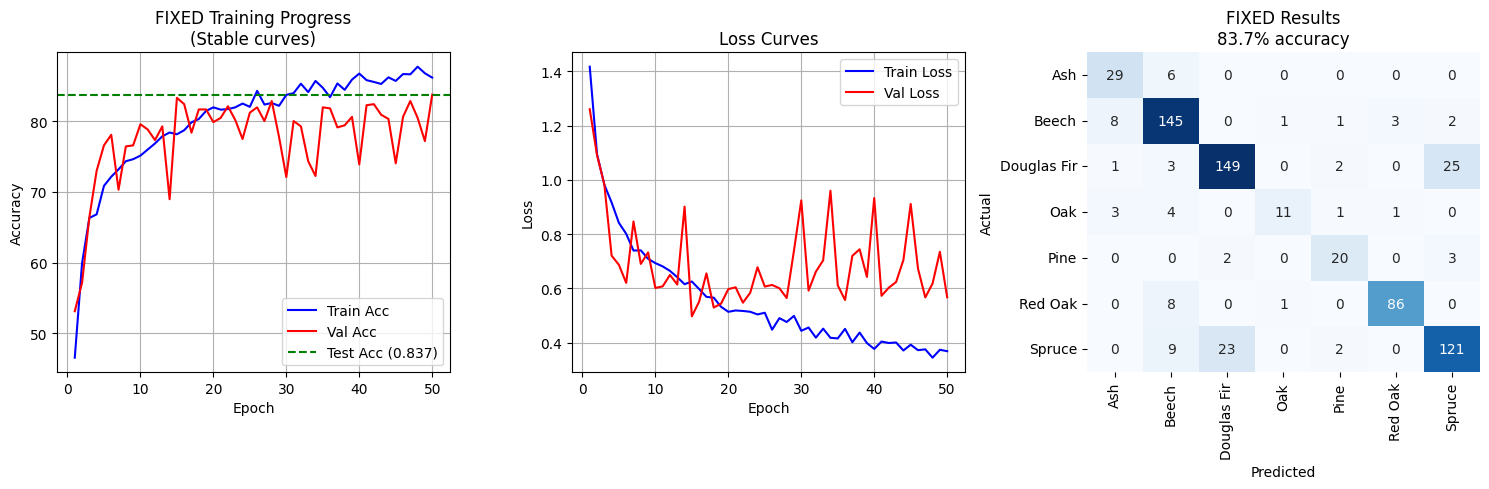

In [43]:
print(f"\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Plot results
plt.figure(figsize=(15, 5))

# Training curves
plt.subplot(1, 3, 1)
epochs = range(1, len(history['train_acc']) + 1)
plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
test_accuracy = all_acc / 100  # Convert to fraction
plt.axhline(y=test_accuracy * 100, color='g', linestyle='--', label=f'Test Acc ({test_accuracy:.3f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FIXED Training Progress\n(Stable curves)')
plt.legend()
plt.grid(True)

# Loss curves
plt.subplot(1, 3, 2)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

# Confusion matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
		xticklabels=train_set.classes, yticklabels=train_set.classes)
plt.title(f'FIXED Results\n{test_accuracy:.1%} accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

